In [272]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path


In [273]:
# # Load the dataset (replace 'songs.csv' with your actual file)
file_path = Path('Resources/spotify_dataset.csv')
songs_df = pd.read_csv(file_path)
songs_df.shape

(41099, 20)

In [274]:
# Remove duplicate songs
songs_df = songs_df.drop_duplicates(subset=['track', 'artist'], keep='first')

print(f"DataFrame after removing duplicates: {songs_df.shape}")

DataFrame after removing duplicates: (39996, 20)


In [275]:
songs_df['decade'] = songs_df['decade'].replace({
    '60s': 1960.0,
    '70s': 1970.0,
    '80s': 1980.0,
    '90s': 1990.0,
    '00s': 2000.0, 
    '10s': 2010.0
}).astype(float)

/var/folders/zb/zlwnk3g95gq8bzw6chr9cs_m0000gn/T/ipykernel_28924/2433580227.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  songs_df['decade'] = songs_df['decade'].replace({


In [284]:
# Select relevant features for the model

features = [
# 'track',
#  'artist',
#  'uri',
 'danceability',
 'energy',
#  'key',
 'loudness',
#  'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
#  'duration_ms',
#  'time_signature',
#  'chorus_hit',
#  'sections',
#  'popularity',
#  'decade'
 ]
X = songs_df[features]



In [285]:
print(X.dtypes)

danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object


In [286]:
# Scale the features

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [287]:
X.head(6)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.417,0.620,-7.727,0.0403,0.490,0.000000,0.0779,0.845,185.655
1,0.498,0.505,-12.475,0.0337,0.018,0.107000,0.1760,0.797,101.801
2,0.657,0.649,-13.392,0.0380,0.846,0.000004,0.1190,0.908,115.940
3,0.590,0.545,-12.058,0.1040,0.706,0.024600,0.0610,0.967,105.592
4,0.515,0.765,-3.515,0.1240,0.857,0.000872,0.2130,0.906,114.617
5,0.697,0.673,-10.573,0.0266,0.714,0.919000,0.1220,0.778,112.117


In [288]:
print(X_scaled[5])

[0.70546559 0.6729179  0.72985263 0.02770833 0.71686747 0.919
 0.11054767 0.7811245  0.46440066]


In [289]:
# Train a k-Nearest Neighbors model
model = NearestNeighbors(n_neighbors=15, algorithm='ball_tree')
model.fit(X_scaled)

NearestNeighbors(algorithm='ball_tree', n_neighbors=15)

In [293]:
def recommend_songs(song_title, artist_name, num_recommendations=5):

    # Filter the dataset for the input song and artist
    song_row = songs_df[(songs_df['track'] == song_title) & (songs_df['artist'] == artist_name)]
    
    if song_row.empty:
        print(f"Error: Song '{song_title}' by '{artist_name}' not found in the dataset.")
        return

    # Get the index and features of the input song
    song_index = song_row.index[0]
    song_features = X_scaled[song_index].reshape(1, -1)

    # Find nearest neighbors
    distances, indices = model.kneighbors(song_features)
    
    # Exclude the input song and filter by different artists
    recommendations = []
    for i in indices.flatten():
        if songs_df.loc[i, 'artist'] != artist_name:
            recommendations.append((songs_df.loc[i, 'track'], songs_df.loc[i, 'artist']))
        if len(recommendations) >= num_recommendations:
            break

    # Print recommendations
    print(f"Recommendations for '{song_title}' by {artist_name}:")
    for track, artist in recommendations:
        print(f"- {track} by {artist}")

recommend_songs("Take It Easy", "Eagles", 8)

Recommendations for 'Take It Easy' by Eagles:
- Hace Sonar la Giralda (Tientos-Tangos) by Chiquetete
- You Were Only Fooling (While I Was Falling In Love) by Vic Damone
- Sonata No. 8 in C Minor for Piano, Op. 13 "Pathétique": II. Adagio cantabile by Ludwig van Beethoven
- A Hard Day's Night by Ramsey Lewis Trio
- I Say A Little Prayer/By The Time I Get To Phoenix by Glen Campbell/Anne Murray
- Falador Passa Mal by Os Originais Do Samba
- Don't Spread It Around by Barbara Lynn
- With a Vamp in the Middle by John Hartford


In [294]:
from time import time

algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
for algo in algorithms:
    start_time = time()
    model = NearestNeighbors(n_neighbors=15, algorithm=algo)
    model.fit(X_scaled)
    print(f"Algorithm: {algo}, Time Taken: {time() - start_time:.4f} seconds")

Algorithm: auto, Time Taken: 0.0180 seconds
Algorithm: ball_tree, Time Taken: 0.0133 seconds
Algorithm: kd_tree, Time Taken: 0.0103 seconds
Algorithm: brute, Time Taken: 0.0005 seconds


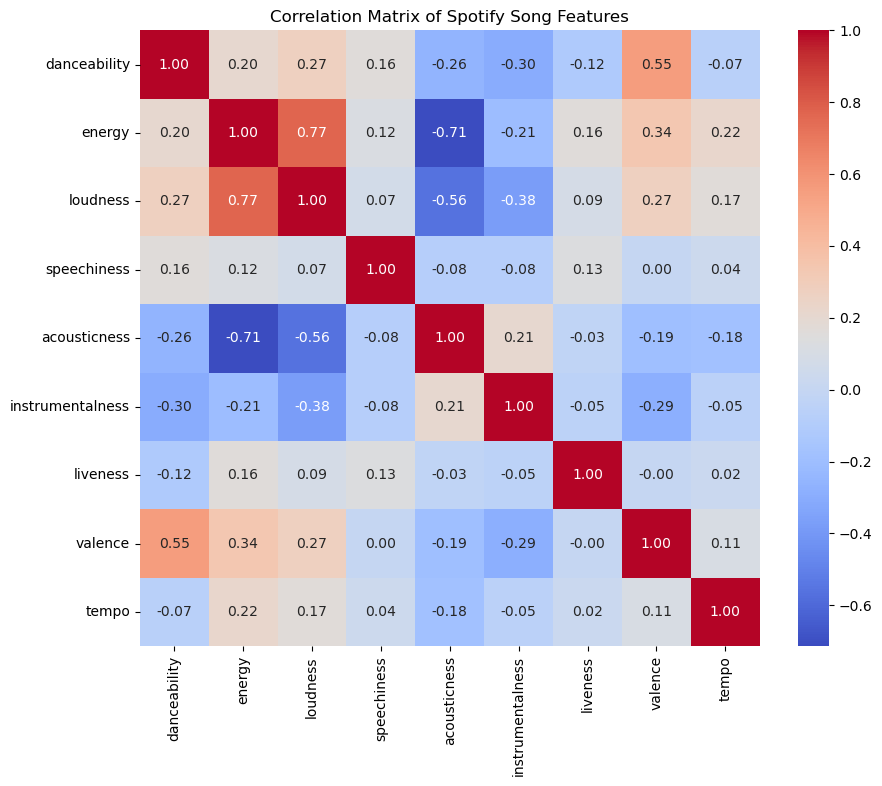

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for the original features (before scaling)
correlation_matrix = X.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Spotify Song Features")
plt.show()